In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

In [2]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [3]:
# Use Principal Component Analysis to reduce the dimensionality of the data

pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()


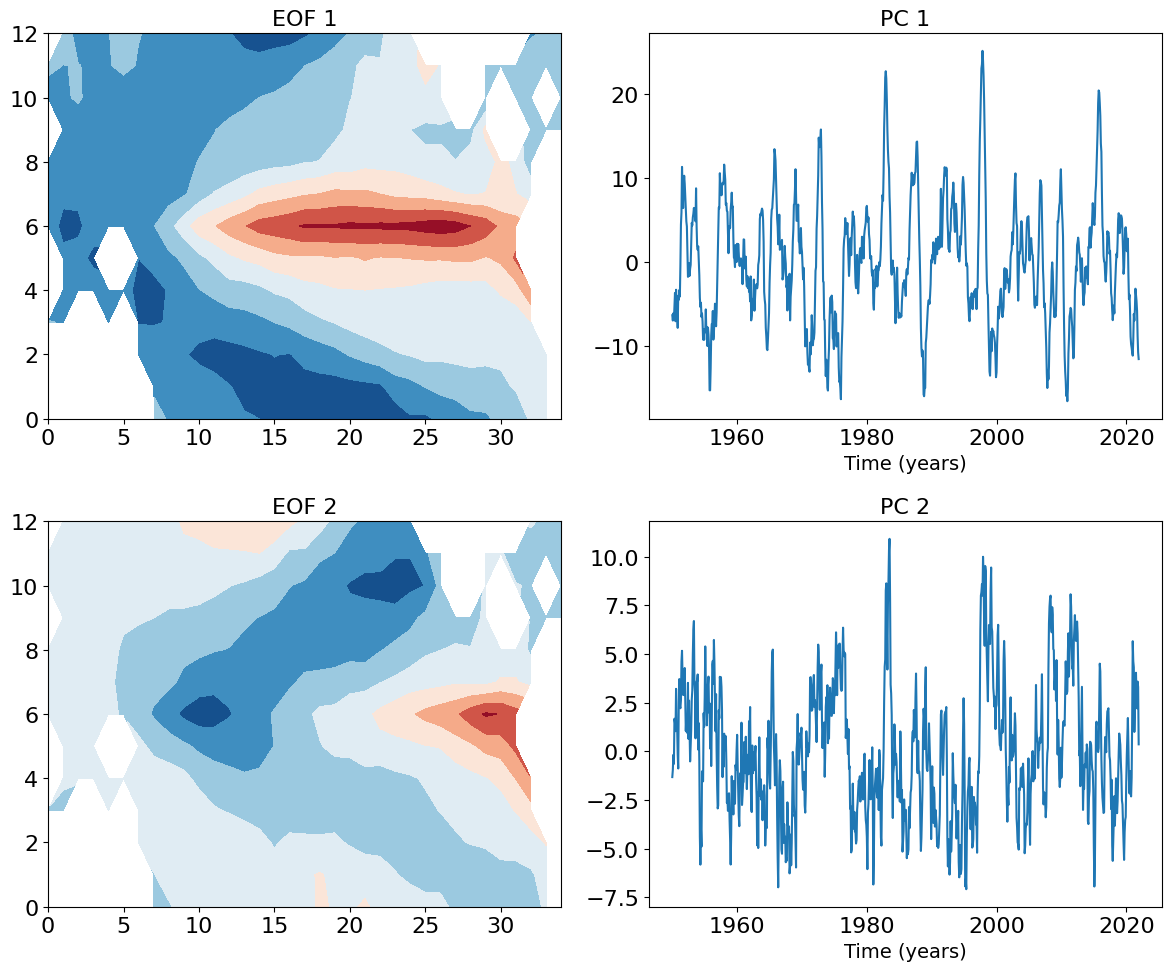

In [4]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [5]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [6]:
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)
print("Data train : {} + shape: {}".format(type(data_train.data), data_train.data.shape))

Frobenius norm: 0.7288174826019497
Data train : <class 'numpy.ndarray'> + shape: (10, 691)


In [7]:
# Simulate stochastic differential equation
x_input = data_test.isel(time=0)
times = x_input['time']
x = x_input.data

noise_integration_arr = model.noise_integration(x, timesteps=49)


t_delta : 2.3123952553987728


Performing LIM forecast for tau values: [1, 2, 3]


Text(0.5, 1.0, 'Noise Integration')

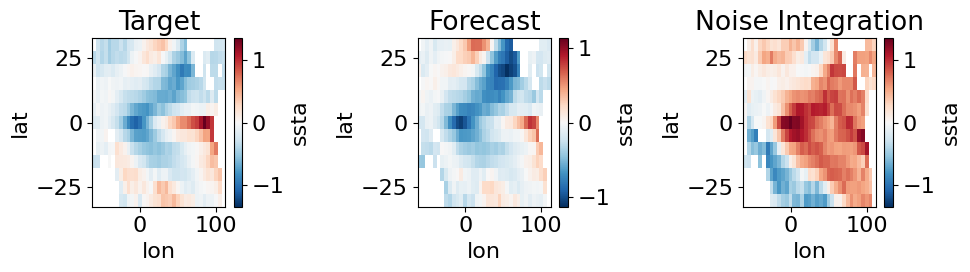

In [8]:
lag = 1
time_index = 10

x_input = data_test.isel(time=np.arange(0,50))
times = x_input['time']
x = x_input.data

forecast_output = model.forecast(x, [1,2,3])
forecast_output = forecast_output[lag, : , :]

noise_integration_arr = noise_integration_arr.T

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(forecast_output[:, :-lag], newdim=times[lag:])
reconstructed_forecast_integration = pca_10.reconstruction(noise_integration_arr[:, :-lag], newdim=times[lag:])


# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,3, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")
reconstructed_forecast_integration.isel(time=time_index).plot(ax=axs[2])
axs[2].set_title("Noise Integration")


Performing LIM forecast for tau values: [1, 2, 3]
t_delta : 2.3123952553987728
X_frcst : <class 'numpy.ndarray'> + shape : (10, 100)
X : <class 'numpy.ndarray'> + shape : (10, 100)


Text(0.5, 0, 'Time')

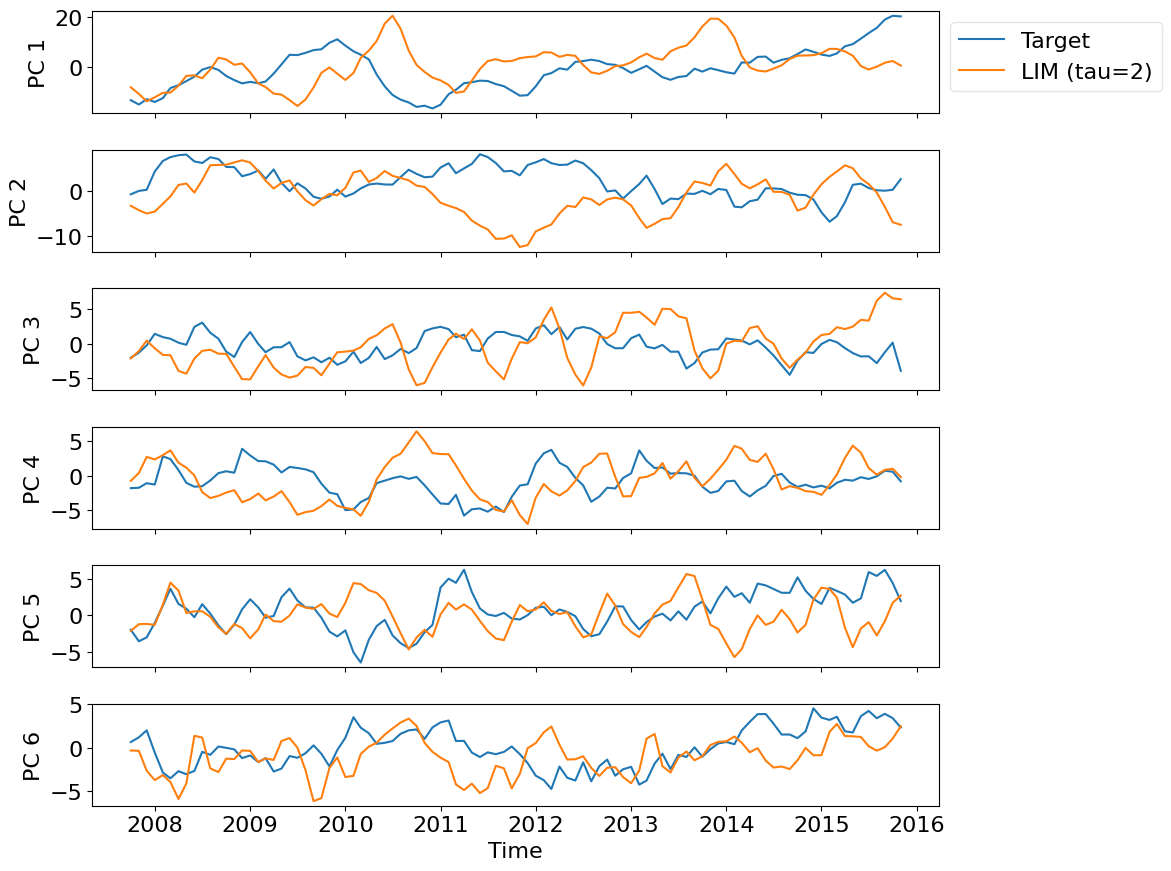

In [9]:
# Forecasting

# Define lag
lag = 2

# Get input data
x_target = data_test.isel(time=np.arange(0, 100))
times = x_target['time']
x = x_target.data

#forecast_output = model.forecast_mean(x, lag=lag)
forecast_output = model.forecast(x, [1,2,3])
forecast_output = forecast_output[lag, : , :]

# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

# Forecast mean using LIM model
noise_integration_arr = model.noise_integration(x_input, timesteps=99)
noise_integration_arr = noise_integration_arr.T
#output_array = forecast_output2

# Plot time evolution of selected components
idx_components = [0, 1, 2, 3, 4, 5]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

print("X_frcst : {} + shape : {}".format(type(noise_integration_arr), noise_integration_arr.shape))
print("X : {} + shape : {}".format(type(x), x.shape))

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], noise_integration_arr[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {i+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')

In [10]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]

# original fit
tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

logar_matr = model.logarithmic_matrix
noise_matr = model.noise_covariance


# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

# Forecast mean using LIM model
noise_integration_arr = model.noise_integration(x_input, timesteps=10000)
noise_integration_arr = noise_integration_arr.T

print("Output array : {} + shape : {}".format(noise_integration_arr, noise_integration_arr.shape))
print("Data train : {} + shape : {}".format(data_train.data, data_train.data.shape))

tau = 1
model2 = LIM_class.LIM(tau)
model2.fit(noise_integration_arr)

logar_matr2 = model2.logarithmic_matrix
noise_matr2 = model2.noise_covariance

print("Logar_matr : {} + shape : {}".format(logar_matr, logar_matr.shape))
print("Logar_matr2 : {} + shape : {}".format(logar_matr2, logar_matr2.shape))
print("Noise_matr : {} + shape : {}".format(noise_matr, noise_matr.shape))
print("Noise_matr2 : {} + shape : {}".format(noise_matr2, noise_matr2.shape))




Frobenius norm: 0.7288174826019497
t_delta : 2.3123952553987728
Output array : [[ -8.08248359 -10.30573117 -12.60629899 ... -17.0924506  -14.41267582
   -8.48502206]
 [ -3.38374856  -4.19035815  -4.68802935 ...  -1.03767318   0.79508544
    2.10833001]
 [ -2.1527585   -1.47678647   0.96634752 ...  -0.82053156  -2.54686159
   -4.56267461]
 ...
 [ -0.99610547  -3.38017897  -2.51394464 ...   0.08201435   1.37950274
    1.17983026]
 [ -0.83593562  -0.42001292   1.3885591  ...   1.45359738   1.55860389
    1.31960242]
 [ -1.42829757   0.64656827   2.48618643 ...   0.57643895   0.89321134
    1.08485963]] + shape : (10, 10001)
Data train : [[-6.29767607 -6.92623833 -6.06612333 ... -5.33055296 -4.86835222
  -6.0603949 ]
 [-1.32017403 -0.94989195 -0.17729696 ... -2.09860531 -2.16949402
  -2.62321542]
 [-2.06665348 -2.59613491 -2.8277156  ... -1.22104008 -2.5095812
  -1.09307032]
 ...
 [ 0.46678688  0.63504274  0.63570634 ... -5.2236353  -5.79783524
  -3.26088812]
 [ 1.10646974  0.45364603  0.1

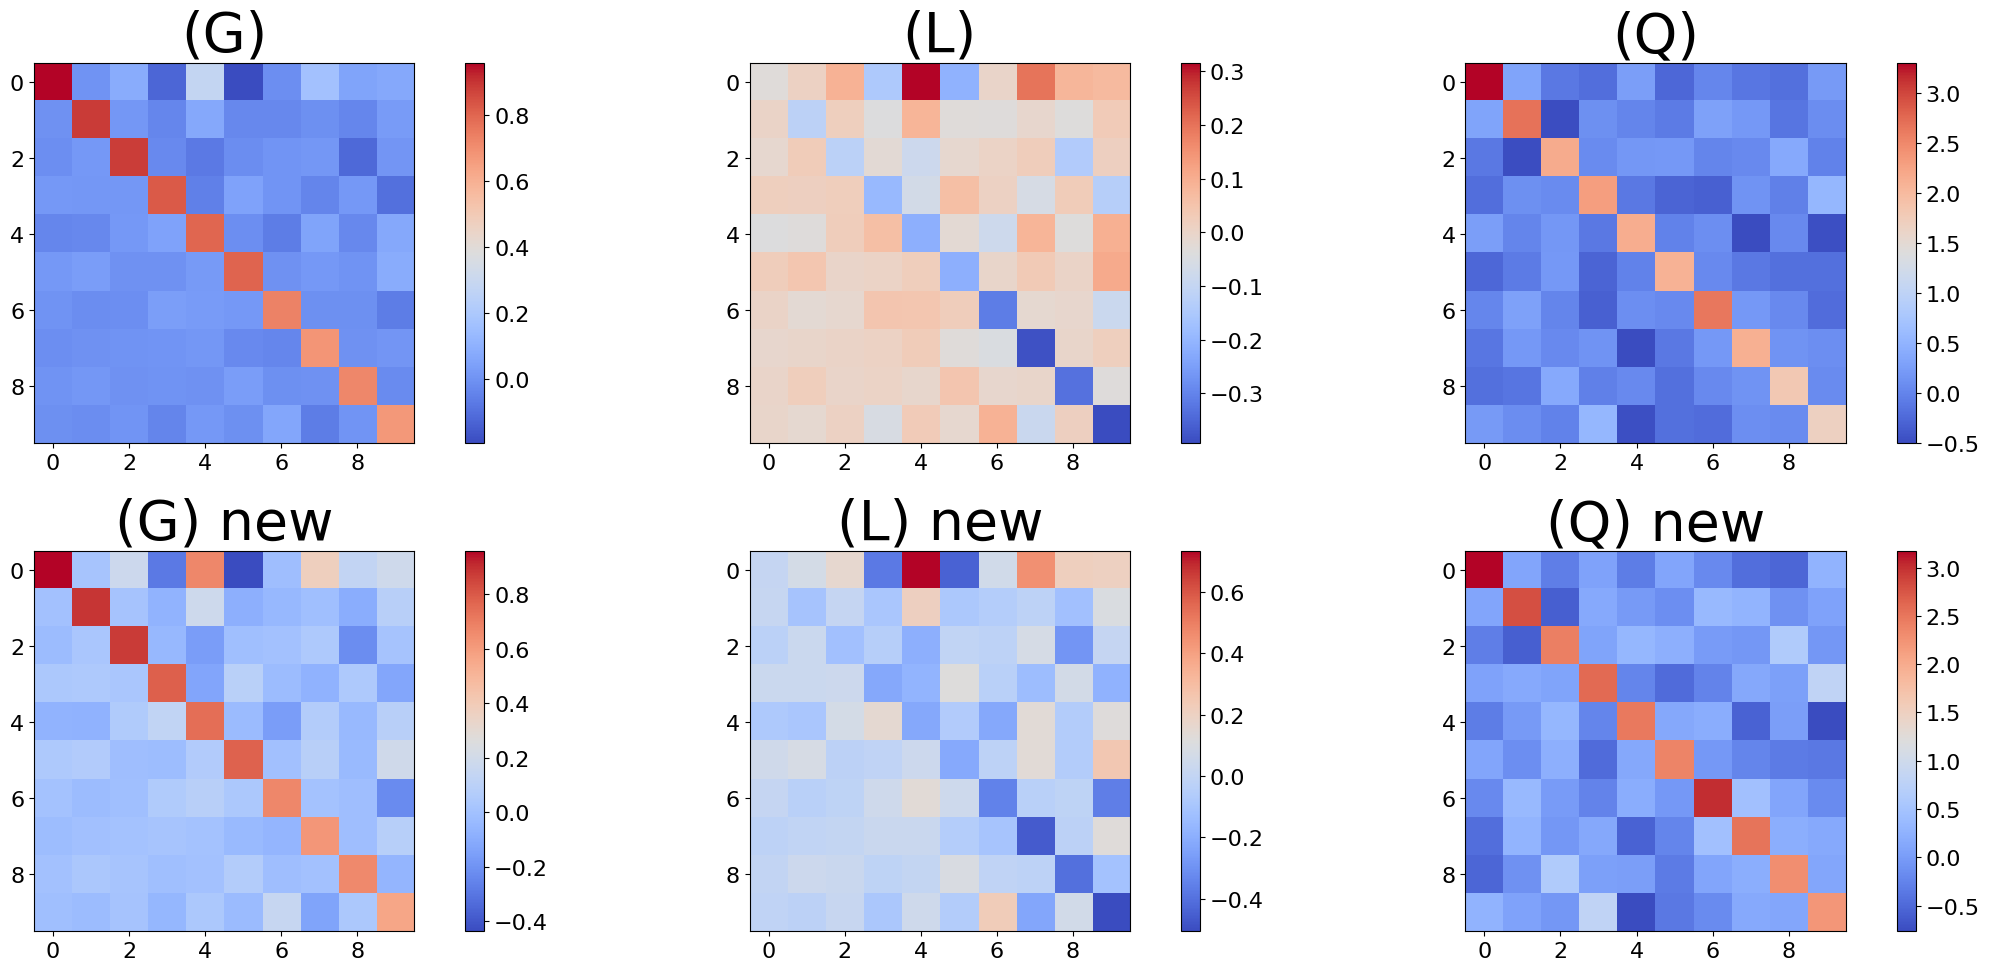

In [11]:
# Plot G, L, Q
fig, axs = plt.subplots(2, 3, figsize=(25, 10))

# Plot G
im1 = axs[0][0].imshow(model.green_function, cmap='coolwarm')
axs[0][0].set_title('(G)', fontsize=40)
fig.colorbar(im1, ax=axs[0][0])
im11 = axs[1][0].imshow(model2.green_function, cmap='coolwarm')
axs[1][0].set_title('(G) new', fontsize=40)
fig.colorbar(im11, ax=axs[1][0])

# Plot L
im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[0][1].set_title('(L)', fontsize=40)
fig.colorbar(im2, ax=axs[0][1])
im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix), cmap='coolwarm')
axs[1][1].set_title('(L) new', fontsize=40)
fig.colorbar(im21, ax=axs[1][1])

# Plot Q
im3 = axs[0][2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[0][2].set_title('(Q)', fontsize=40)
fig.colorbar(im3, ax=axs[0][2])
im31 = axs[1][2].imshow(np.real(model2.noise_covariance), cmap='coolwarm')
axs[1][2].set_title('(Q) new', fontsize=40)
fig.colorbar(im31, ax=axs[1][2])

plt.tight_layout()
plt.show()